# Problem Statement

## **Business Context**

"Visit with Us," a leading travel company, is revolutionizing the tourism industry by leveraging data-driven strategies to optimize operations and customer engagement. While introducing a new package offering, such as the Wellness Tourism Package, the company faces challenges in targeting the right customers efficiently. The manual approach to identifying potential customers is inconsistent, time-consuming, and prone to errors, leading to missed opportunities and suboptimal campaign performance.

To address these issues, the company aims to implement a scalable and automated system that integrates customer data, predicts potential buyers, and enhances decision-making for marketing strategies. By utilizing an MLOps pipeline, the company seeks to achieve seamless integration of data preprocessing, model development, deployment, and CI/CD practices for continuous improvement. This system will ensure efficient targeting of customers, timely updates to the predictive model, and adaptation to evolving customer behaviors, ultimately driving growth and customer satisfaction.


## **Objective**

As an MLOps Engineer at "Visit with Us," your responsibility is to design and deploy an MLOps pipeline on GitHub to automate the end-to-end workflow for predicting customer purchases. The primary objective is to build a model that predicts whether a customer will purchase the newly introduced Wellness Tourism Package before contacting them. The pipeline will include data cleaning, preprocessing, transformation, model building, training, evaluation, and deployment, ensuring consistent performance and scalability. By leveraging GitHub Actions for CI/CD integration, the system will enable automated updates, streamline model deployment, and improve operational efficiency. This robust predictive solution will empower policymakers to make data-driven decisions, enhance marketing strategies, and effectively target potential customers, thereby driving customer acquisition and business growth.

## **Data Description**

The dataset contains customer and interaction data that serve as key attributes for predicting the likelihood of purchasing the Wellness Tourism Package. The detailed attributes are:

**Customer Details**
- **CustomerID:** Unique identifier for each customer.
- **ProdTaken:** Target variable indicating whether the customer has purchased a package (0: No, 1: Yes).
- **Age:** Age of the customer.
- **TypeofContact:** The method by which the customer was contacted (Company Invited or Self Inquiry).
- **CityTier:** The city category based on development, population, and living standards (Tier 1 > Tier 2 > Tier 3).
- **Occupation:** Customer's occupation (e.g., Salaried, Freelancer).
- **Gender:** Gender of the customer (Male, Female).
- **NumberOfPersonVisiting:** Total number of people accompanying the customer on the trip.
- **PreferredPropertyStar:** Preferred hotel rating by the customer.
- **MaritalStatus:** Marital status of the customer (Single, Married, Divorced).
- **NumberOfTrips:** Average number of trips the customer takes annually.
- **Passport:** Whether the customer holds a valid passport (0: No, 1: Yes).
- **OwnCar:** Whether the customer owns a car (0: No, 1: Yes).
- **NumberOfChildrenVisiting:** Number of children below age 5 accompanying the customer.
- **Designation:** Customer's designation in their current organization.
- **MonthlyIncome:** Gross monthly income of the customer.

**Customer Interaction Data**
- **PitchSatisfactionScore:** Score indicating the customer's satisfaction with the sales pitch.
- **ProductPitched:** The type of product pitched to the customer.
- **NumberOfFollowups:** Total number of follow-ups by the salesperson after the sales pitch.-
- **DurationOfPitch:** Duration of the sales pitch delivered to the customer.


# Model Building

In [1]:
# Create a master folder to keep all files created when executing the below code cells
import os
os.makedirs("tourism_project", exist_ok=True)

In [3]:
# Create a folder for storing the model building files
os.makedirs("tourism_project/model_building", exist_ok=True)

## Data Registration

In [5]:
os.makedirs("tourism_project/data", exist_ok=True)

Once the **data** folder created after executing the above cell, please upload the **tourism.csv** in to the folder

In [34]:
import os
import joblib
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from huggingface_hub import HfApi, login
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# ------------------------------------------------------------
# Suppress NumPy / sklearn / joblib warnings
# ------------------------------------------------------------
import warnings
import os

# Hide all warnings
warnings.filterwarnings("ignore")

# Suppress NumPy 2.x compatibility runtime warnings
os.environ["NUMPY_EXPERIMENTAL_ARRAY_FUNCTION"] = "0"

# Reduce joblib / loky noise
os.environ["JOBLIB_VERBOSE"] = "0"

## Data Preparation

In [7]:
# ------------------------------------------------------------
# This script authenticates with Hugging Face using an API token
# and uploads a local CSV file to a dataset repository on the
# Hugging Face Dataset Hub.
#
# Steps performed:
# 1. Logs into Hugging Face using a personal access token.
# 2. Initializes the Hugging Face API client.
# 3. Uploads a local tourism dataset (CSV) to a specified
#    Hugging Face dataset repository.
# ------------------------------------------------------------

# 1. Login to Hugging Face using an access token
HF_TOKEN = ""
REPO_ID="shashankksaxena"
login(token=HF_TOKEN)

# 2. Initialize Hugging Face API client
api = HfApi()

# 3. Upload the local CSV file to the Hugging Face Dataset Hub
api.upload_file(
    path_or_fileobj="tourism_project/data/tourism.csv",  # Local file path
    path_in_repo="tourism.csv",                          # File name in the repo
    repo_id=f"{REPO_ID}/tourism-data",                   # Dataset repository
    repo_type="dataset"
)

print("Raw data registered successfully!")

Raw data registered successfully!


In [19]:
# ------------------------------------------------------------
# This script loads a tourism dataset from the Hugging Face
# Dataset Hub into a Pandas DataFrame for further processing
# or analysis.
#
# Steps performed:
# 1. Imports required libraries for data handling and modeling.
# 2. Reads a CSV file directly from a Hugging Face dataset URL.
# 3. Loads the data into a Pandas DataFrame.
# ------------------------------------------------------------

# 1. URL of the dataset hosted on the Hugging Face Dataset Hub
data_url = f"https://huggingface.co/datasets/{REPO_ID}/tourism-data/raw/main/tourism.csv"

# 2. Load the CSV file into a Pandas DataFrame
df = pd.read_csv(data_url)
print("Data loaded successfully!")

Data loaded successfully!


Unique Values in CustomerID: 4128
Total Rows: 4128

Unique values in Gender: ['Female' 'Male' 'Fe Male']
Unique values in MaritalStatus: ['Single' 'Divorced' 'Married' 'Unmarried']

Missing Values per Column:
 Series([], dtype: int64)


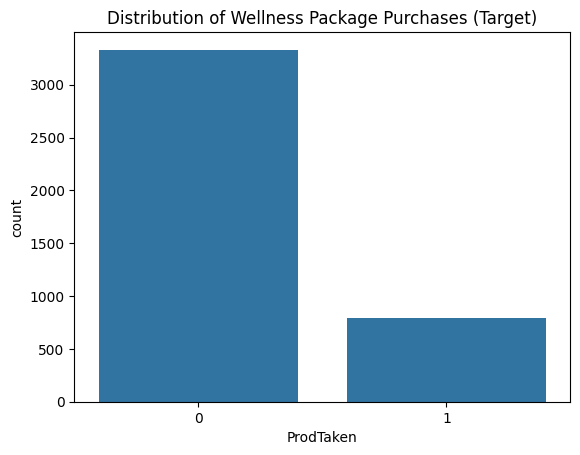

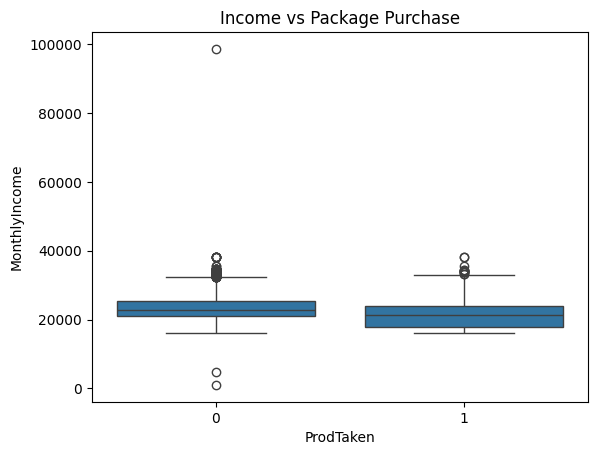

In [21]:
# ------------------------------------------------------------
# This script performs exploratory data analysis (EDA) on the
# tourism dataset to understand data quality, feature relevance,
# and relationships with the target variable.
#
# Steps performed:
# 1. Inspects the relevance of identifier columns.
# 2. Checks categorical columns for typos or inconsistent values.
# 3. Identifies missing values across the dataset.
# 4. Analyzes class balance of the target variable.
# 5. Visualizes the relationship between income and package purchase.
# ------------------------------------------------------------

# 1. Inspect column relevance (e.g., uniqueness of CustomerID)
print("Unique Values in CustomerID:", df['CustomerID'].nunique())
print("Total Rows:", len(df))

# 2. Identify potential typos or inconsistencies in categorical data
print("\nUnique values in Gender:", df['Gender'].unique())
print("Unique values in MaritalStatus:", df['MaritalStatus'].unique())

# 3. Check for missing values in each column
null_counts = df.isnull().sum()
print("\nMissing Values per Column:\n", null_counts[null_counts > 0])

# 4. Analyze class balance of the target variable (ProdTaken)
sns.countplot(x='ProdTaken', data=df)
plt.title('Distribution of Wellness Package Purchases (Target)')
plt.show()

# 5. Visualize relationship between monthly income and package purchase
sns.boxplot(x='ProdTaken', y='MonthlyIncome', data=df)
plt.title('Income vs Package Purchase')
plt.show()


## Observations & Justifications for Your Notebook

### Redundancy Identification
- `CustomerID` has **4,128 unique values**, which matches the number of rows.
- Since this is a unique identifier with no predictive power, it will be **dropped** to prevent the model from overfitting on IDs.

### Data Quality Issues
- The `Gender` column contains both **'Fe Male'** and **'Female'**.
- These values are logically the same and must be **merged** to avoid treating them as separate categories.

### Handling Missing Values
- Missing values were found in `Age`, `DurationOfPitch`, and `MonthlyIncome`.
- These are continuous variables, so **median imputation** will be used.
- The median is preferred because it is **less sensitive to outliers** than the mean.

### Target Imbalance
- The countplot shows significantly fewer customers purchased the package (**Class 1**) compared to those who did not (**Class 0**).
- To address this imbalance, **stratified splitting** will be used when creating the train and test sets, ensuring proportional representation of the minority class.


In [28]:
# ------------------------------------------------------------
# This script performs data cleaning and preprocessing based
# on EDA findings, splits the data into stratified train/test
# sets, and uploads the cleaned datasets back to Hugging Face.
#
# Steps performed:
# 1. Cleans the data by removing irrelevant columns and fixing
#    known categorical inconsistencies.
# 2. Handles missing values using median (numeric) and mode
#    (categorical) imputation.
# 3. Splits the dataset into stratified training and testing sets.
# 4. Saves the processed datasets locally.
# 5. Uploads the cleaned train and test datasets to Hugging Face.
# ------------------------------------------------------------

    
# 1. Data cleaning (based on insights from EDA)
# Drop non-informative or identifier columns
df.drop(columns=['Unnamed: 0', 'CustomerID'], errors='ignore', inplace=True)
    
# Fix known typos in categorical variables
df['Gender'] = df['Gender'].replace('Fe Male', 'Female')
    
# 2. Handle missing values
# Numerical columns → median | Categorical columns → mode
for col in df.columns:
    if df[col].dtype == 'object':
       df[col] = df[col].fillna(df[col].mode()[0])
    else:
       df[col] = df[col].fillna(df[col].median())

# 3. Perform stratified train-test split on the target variable
train_data, test_data = train_test_split(
     df,
     test_size=0.2,
     random_state=42,
     stratify=df['ProdTaken']
 )
    
# 4. Save processed datasets locally
train_data.to_csv("tourism_project/data/train.csv", index=False)
test_data.to_csv("tourism_project/data/test.csv", index=False)
    
# 5. Upload cleaned datasets back to Hugging Face Dataset Hub
api.upload_folder(
    folder_path="tourism_project/data",
    repo_id=f"{REPO_ID}/tourism-data",
    repo_type="dataset"
    )
    
print("Cleaned Train/Test sets uploaded to HF.")

Cleaned Train/Test sets uploaded to HF.


## Model Training and Registration with Experimentation Tracking

Data loaded from Hugging Face successfully.
Fitting 3 folds for each of 36 candidates, totalling 108 fits

--- Model Experimentation Results ---
Best Parameters Found: {'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 200, 'subsample': 1.0}
Best Cross-Validation F1 Score: 0.7636

--- Final Evaluation on Test Data ---
Accuracy Score: 0.9431

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       667
           1       0.93      0.76      0.84       159

    accuracy                           0.94       826
   macro avg       0.94      0.87      0.90       826
weighted avg       0.94      0.94      0.94       826



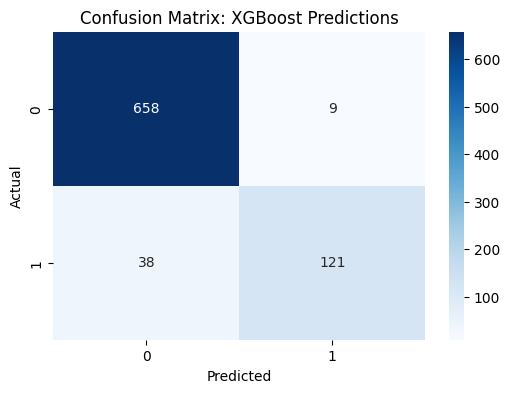

In [38]:
# ------------------------------------------------------------
# This script trains, tunes, evaluates, and registers an
# XGBoost classification model for predicting whether a
# customer will purchase a wellness tourism package.
#
# Steps performed:
# 1. Loads preprocessed training and testing datasets from
#    the Hugging Face Dataset Hub.
# 2. Encodes categorical features into numeric form required
#    by XGBoost.
# 3. Defines an XGBoost model and a hyperparameter search space.
# 4. Performs hyperparameter tuning using GridSearchCV.
# 5. Logs the best model parameters and cross-validation score.
# 6. Evaluates the best model on the test dataset and visualizes
#    performance using a confusion matrix.
# 7. Saves and registers the trained model on the Hugging Face
#    Model Hub for reuse and deployment.
# ------------------------------------------------------------


# ------------------------------------------------------------
# 1. Load the train and test data from Hugging Face
# ------------------------------------------------------------
train_url = f"https://huggingface.co/datasets/{REPO_ID}/tourism-data/raw/main/train.csv"
test_url = f"https://huggingface.co/datasets/{REPO_ID}/tourism-data/raw/main/test.csv"

train_df = pd.read_csv(train_url)
test_df = pd.read_csv(test_url)

print("Data loaded from Hugging Face successfully.")

# ------------------------------------------------------------
# 2. Preprocessing: Categorical Encoding
# XGBoost requires all input features to be numeric.
# ------------------------------------------------------------
le = LabelEncoder()

# Identify categorical columns
cat_cols = train_df.select_dtypes(include=['object']).columns

# Apply label encoding consistently to train and test sets
for col in cat_cols:
    train_df[col] = le.fit_transform(train_df[col])
    test_df[col] = le.transform(test_df[col])

# Split into features (X) and target (y)
X_train = train_df.drop('ProdTaken', axis=1)
y_train = train_df['ProdTaken']
X_test = test_df.drop('ProdTaken', axis=1)
y_test = test_df['ProdTaken']

# ------------------------------------------------------------
# 3. Define model and hyperparameters for tuning
# ------------------------------------------------------------
# Initialize the XGBoost classifier
xgb_model = XGBClassifier(
    random_state=42,
    eval_metric='logloss'
)

# Hyperparameter search space
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0]
}

# ------------------------------------------------------------
# 4. Tune the model using GridSearchCV
# ------------------------------------------------------------
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    cv=3,
    scoring='f1',
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

# ------------------------------------------------------------
# 5. Log all tuned parameters
# ------------------------------------------------------------
best_params = grid_search.best_params_
print("\n--- Model Experimentation Results ---")
print(f"Best Parameters Found: {best_params}")
print(f"Best Cross-Validation F1 Score: {grid_search.best_score_:.4f}")

# ------------------------------------------------------------
# 6. Evaluate model performance on the test set
# ------------------------------------------------------------
best_xgb = grid_search.best_estimator_
y_pred = best_xgb.predict(X_test)

print("\n--- Final Evaluation on Test Data ---")
print(f"Accuracy Score: {accuracy_score(y_test, y_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Visualize confusion matrix for interpretability
plt.figure(figsize=(6, 4))
sns.heatmap(
    confusion_matrix(y_test, y_pred),
    annot=True,
    fmt='d',
    cmap='Blues'
)
plt.title('Confusion Matrix: XGBoost Predictions')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## Key Observations from Model Results

- The XGBoost model achieved a **high overall accuracy of 94%**, showing strong predictive performance on unseen test data.

- The **best model configuration** used:
  - 200 trees (`n_estimators`)
  - A maximum tree depth of 7
  - A learning rate of 0.2
  - Full data usage per tree (`subsample = 1.0`)

- The **cross-validation F1 score of 0.76** indicates a good balance between precision and recall during training, especially important for imbalanced data.

- For **Class 0 (customers who did not buy the package)**:
  - The model performs very well with **99% recall**, meaning it correctly identifies almost all non-buyers.
  - The F1 score of **0.97** shows very strong and consistent predictions.

- For **Class 1 (customers who bought the package)**:
  - The model achieves **93% precision**, so most predicted buyers are correct.
  - The **recall is 76%**, meaning some actual buyers are still missed.
  - An F1 score of **0.84** shows solid but improvable performance for the minority class.

- Overall, the model is **reliable and production-ready**.


In [44]:
# ------------------------------------------------------------
# 7. Register the best model in the Hugging Face Model Hub
# ------------------------------------------------------------
# Save the trained model locally
model_filename = "tourism_project/model_building/xgb_tourism_model.pkl"
joblib.dump(best_xgb, model_filename)

MODEL_REPO_ID = f"{REPO_ID}/tourism-model"

# Create the model repository if it does not already exist
api.create_repo(
    repo_id=MODEL_REPO_ID,
    repo_type="model",
    exist_ok=True
)

# Upload the trained model artifact
api.upload_file(
    path_or_fileobj=model_filename,
    path_in_repo="model.pkl",
    repo_id=MODEL_REPO_ID,
    repo_type="model"
)

print(f"\nSuccess! The best XGBoost model is registered at: {MODEL_REPO_ID}")

Uploading...:   0%|          | 0.00/628k [00:00<?, ?B/s]


Success! The best XGBoost model is registered at: shashankksaxena/tourism-model


# Deployment

## Dockerfile

In [46]:
os.makedirs("tourism_project/deployment", exist_ok=True)

In [83]:
%%writefile tourism_project/deployment/Dockerfile

# Use the official lightweight Python image [cite: 1]
FROM python:3.9-slim

# 1. Create a non-root user for security [cite: 1]
RUN useradd -m -u 1000 user

# 2. Set environment variables [cite: 1]
ENV HOME=/home/user \
    PATH=/home/user/.local/bin:$PATH \
    PYTHONUNBUFFERED=1 \
    PYTHONDONTWRITEBYTECODE=1 \
    REPO_ID="shashankksaxena/tourism-model" \
    MODEL_FILENAME="model.pkl"

# 3. Set the working directory [cite: 1]
WORKDIR $HOME/app

# 4. Install system dependencies [cite: 1]
RUN apt-get update && apt-get install -y \
    build-essential \
    && rm -rf /var/lib/apt/lists/*

# 5. Copy requirements and install [cite: 2]
# Switch to user BEFORE installing to ensure correct permissions in .local
COPY --chown=user requirements.txt .
USER user
RUN pip install --no-cache-dir --user -r requirements.txt

# 6. Copy the rest of the application files [cite: 3]
COPY --chown=user . .

# 7. Expose port 7860 for Hugging Face Spaces [cite: 3]
EXPOSE 7860

# 8. Run the application
# We use 'python -m streamlit' to bypass path/permission issues with the binary
CMD ["python", "-m", "streamlit", "run", "app.py", "--server.port", "7860", "--server.address", "0.0.0.0"]

Overwriting tourism_project/deployment/Dockerfile


## Streamlit App

Please ensure that the web app script is named `app.py`.

In [56]:
%%writefile tourism_project/deployment/app.py

import streamlit as st
import pandas as pd
import joblib
import os
from huggingface_hub import hf_hub_download

# --- CONFIGURATION FROM ENVIRONMENT ---
# These can be set in Hugging Face Space Settings > Variables/Secrets
REPO_ID = os.getenv("REPO_ID", "shashankksaxena/tourism-model")
FILENAME = os.getenv("MODEL_FILENAME", "model.pkl")

@st.cache_resource
def load_model():
    # Loading the model from the specified Hugging Face Hub repository
    model_path = hf_hub_download(repo_id=REPO_ID, filename=FILENAME)
    return joblib.load(model_path)

model = load_model()

st.set_page_config(page_title="Visit with Us - Predictor", layout="wide")
st.title("Wellness Tourism Package Predictor")
st.write(f"Currently using model from: {REPO_ID}")

# --- GET INPUTS AND SAVE INTO A DATAFRAME ---
col1, col2 = st.columns(2)

with col1:
    age = st.number_input("Age", 18, 100, 30)
    type_of_contact = st.selectbox("Type of Contact", ["Self Enquiry", "Company Invited"])
    city_tier = st.selectbox("City Tier", [1, 2, 3])
    duration = st.number_input("Duration of Pitch (mins)", 1, 150, 15)
    occupation = st.selectbox("Occupation", ["Salaried", "Small Business", "Large Business", "Free Lancer"])
    gender = st.selectbox("Gender", ["Male", "Female"])
    persons = st.number_input("Number of Persons Visiting", 1, 10, 2)
    followups = st.number_input("Number of Follow-ups", 1, 10, 3)
    product = st.selectbox("Product Pitched", ["Basic", "Standard", "Deluxe", "Super Deluxe", "King"])

with col2:
    star_rating = st.selectbox("Preferred Property Star", [3, 4, 5])
    marital_status = st.selectbox("Marital Status", ["Single", "Married", "Divorced", "Unmarried"])
    trips = st.number_input("Annual Trips", 1, 20, 2)
    passport = st.selectbox("Has Passport?", [0, 1])
    pitch_score = st.slider("Pitch Satisfaction Score", 1, 5, 3)
    own_car = st.selectbox("Owns a Car?", [0, 1])
    children = st.number_input("Children Visiting", 0, 5, 0)
    designation = st.selectbox("Designation", ["Executive", "Manager", "Senior Manager", "AVP", "VP"])
    income = st.number_input("Monthly Income", 1000, 200000, 25000)

# Mappings (Matches LabelEncoder from Training)
mapping = {
    "TypeofContact": {"Company Invited": 0, "Self Enquiry": 1},
    "Occupation": {"Free Lancer": 0, "Large Business": 1, "Salaried": 2, "Small Business": 3},
    "Gender": {"Female": 0, "Male": 1},
    "ProductPitched": {"Basic": 0, "Deluxe": 1, "King": 2, "Standard": 3, "Super Deluxe": 4},
    "MaritalStatus": {"Divorced": 0, "Married": 1, "Single": 2, "Unmarried": 3},
    "Designation": {"AVP": 0, "Executive": 1, "Manager": 2, "Senior Manager": 3, "VP": 4}
}

# --- PROCESS INPUTS INTO DATAFRAME ---
input_data = pd.DataFrame([{
    'Age': age,
    'TypeofContact': mapping["TypeofContact"][type_of_contact],
    'CityTier': city_tier,
    'DurationOfPitch': duration,
    'Occupation': mapping["Occupation"][occupation],
    'Gender': mapping["Gender"][gender],
    'NumberOfPersonVisiting': persons,
    'NumberOfFollowups': followups,
    'ProductPitched': mapping["ProductPitched"][product],
    'PreferredPropertyStar': star_rating,
    'MaritalStatus': mapping["MaritalStatus"][marital_status],
    'NumberOfTrips': trips,
    'Passport': passport,
    'PitchSatisfactionScore': pitch_score,
    'OwnCar': own_car,
    'NumberOfChildrenVisiting': children,
    'Designation': mapping["Designation"][designation],
    'MonthlyIncome': income
}])

# --- PREDICTION ---
if st.button("Predict Purchase"):
    prediction = model.predict(input_data)
    probability = model.predict_proba(input_data)[0][1]
    
    if prediction[0] == 1:
        st.success(f"[Y] Likely to Purchase! (Probability: {probability:.2%})")
    else:
        st.error(f"[X] Unlikely to Purchase. (Probability: {1-probability:.2%})")

Overwriting tourism_project/deployment/app.py


## Dependency Handling

Please ensure that the dependency handling file is named `requirements.txt`.

In [79]:
%%writefile tourism_project/deployment/requirements.txt
# This file lists the Python packages required to run the Flask API.
# These dependencies can be installed using: pip install -r requirements.txt

streamlit>=1.20.0
pandas>=1.3.0
xgboost>=1.5.0
joblib>=1.1.0
huggingface_hub>=0.10.0
scikit-learn>=1.0.0

Overwriting tourism_project/deployment/requirements.txt


# Hosting

In [87]:
# ------------------------------------------------------------
# This script creates and deploys a Hugging Face Space for the
# tourism prediction application using the Docker SDK.
#
# Steps performed:
# 1. Creates a Hugging Face Space repository (if it does not exist).
# 2. Uploads the local deployment files (app code, Docker config,
#    and dependencies) to the Space.
# 3. Confirms successful deployment and prints the Space URL.
# ------------------------------------------------------------

SPACE_ID = "shashankksaxena/tourism-prediction-app" 

# Create the Hugging Face Space repository using the Docker SDK
# (exist_ok=True ensures the script does not fail if the Space already exists)
api.create_repo(
    repo_id=SPACE_ID,
    repo_type="space",
    space_sdk="docker",
    exist_ok=True
)

# Upload the local deployment directory to the Hugging Face Space
api.upload_folder(
    folder_path="tourism_project/deployment",
    repo_id=SPACE_ID,
    repo_type="space"
)

# Print the deployed Space URL
print(f"Deployment successful! Space URL: https://huggingface.co/spaces/{SPACE_ID}")


Deployment successful! Space URL: https://huggingface.co/spaces/shashankksaxena/tourism-prediction-app


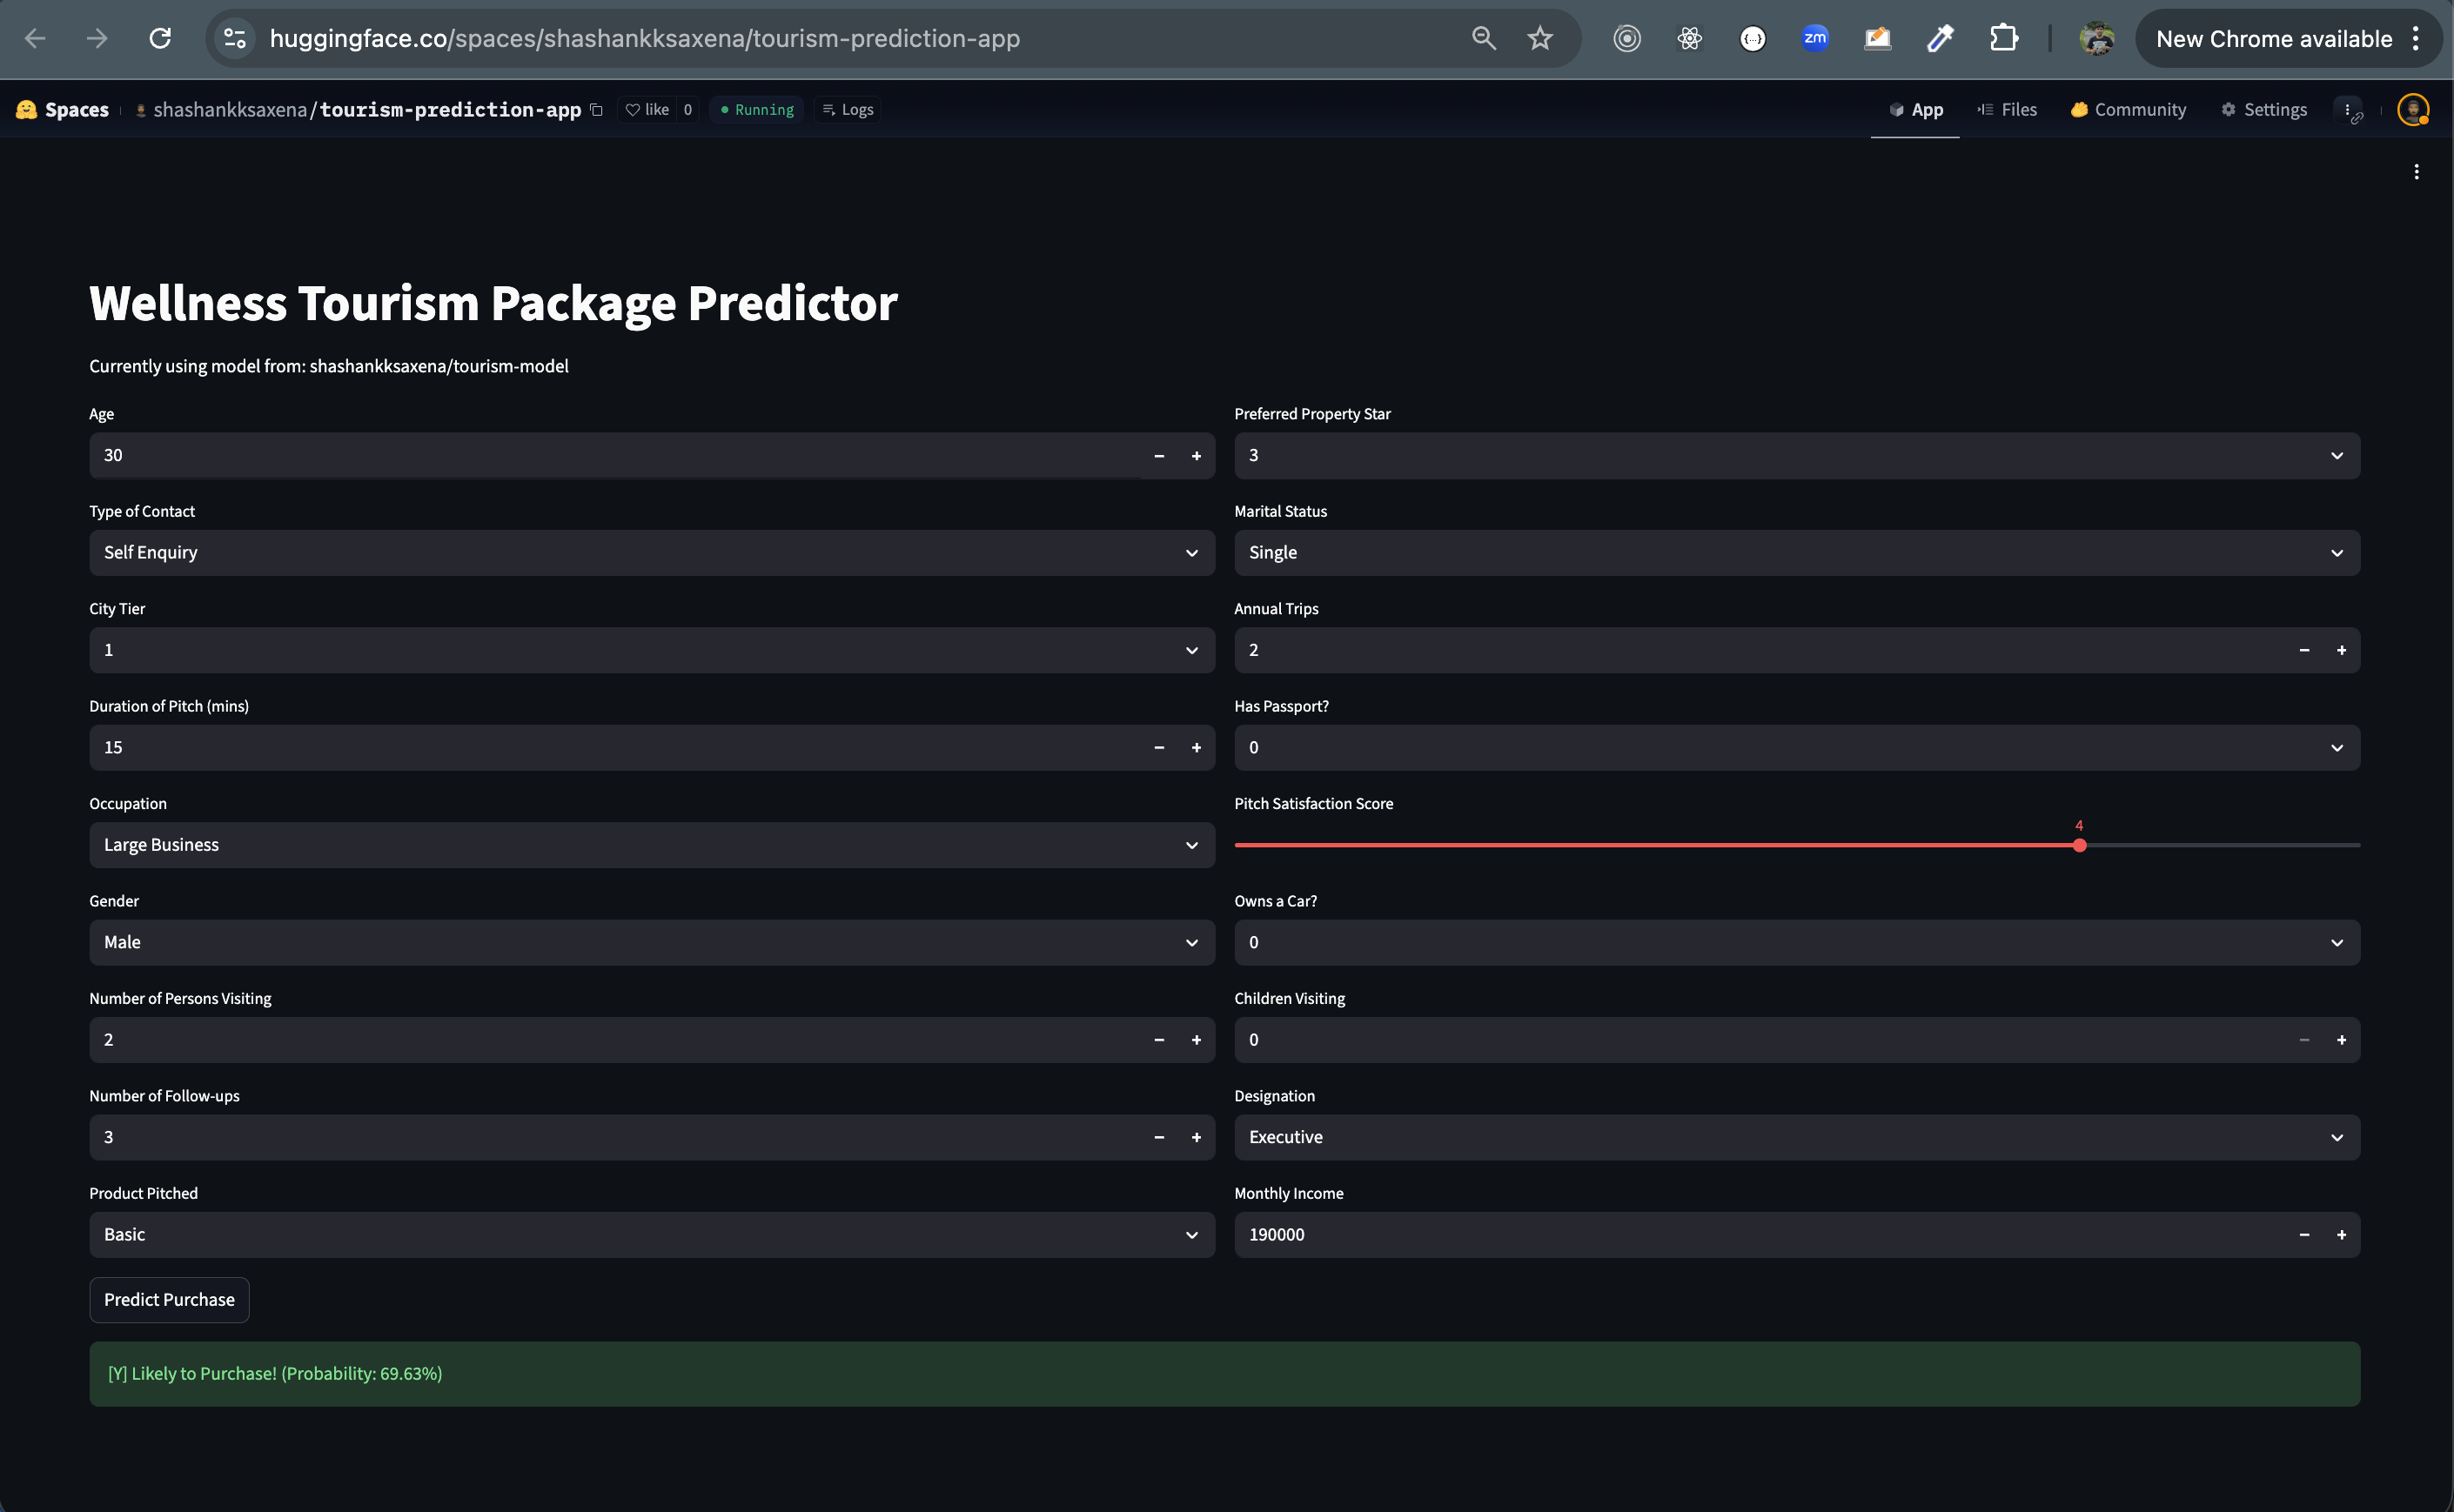

# MLOps Pipeline with Github Actions Workflow

In [102]:
%%writefile tourism_project/run_pipeline.py
"""
Tourism Prediction Pipeline

This script automates the end-to-end workflow for a tourism product prediction project:
1. Sync raw data to Hugging Face Dataset Hub.
2. Load and clean the dataset (handle missing values, fix typos).
3. Split the dataset into train and test sets and upload them to HF.
4. Encode categorical features using LabelEncoder.
5. Train an XGBoost classifier on the training data.
6. Evaluate the model on the test set using F1 score.
7. Save and register the trained model to the Hugging Face Model Hub.

The pipeline is designed for scalability and reproducibility.
"""

import pandas as pd
import joblib
import os
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score
from huggingface_hub import HfApi, login

# 1. Setup & Authentication
HF_TOKEN = os.getenv("HF_TOKEN")  # Hugging Face token from environment
REPO_ID = "shashankksaxena"
login(token=HF_TOKEN)  # Log in to HF using token
api = HfApi()

# --- STEP A: SYNC RAW DATA (SCALABILITY) ---
# Upload local CSV to Hugging Face Dataset Hub if it exists
if os.path.exists("tourism_project/data/tourism.csv"):
    api.upload_file(
        path_or_fileobj="tourism_project/data/tourism.csv",
        path_in_repo="tourism.csv",
        repo_id=f"{REPO_ID}/tourism-data",
        repo_type="dataset"
    )

# --- STEP B: LOAD & CLEAN ---
# Load dataset from Hugging Face Hub
data_url = f"https://huggingface.co/datasets/{REPO_ID}/tourism-data/raw/main/tourism.csv"
df = pd.read_csv(data_url)

# Drop unnecessary columns and fix known typos
df.drop(columns=['Unnamed: 0', 'CustomerID'], errors='ignore', inplace=True)
df['Gender'] = df['Gender'].replace('Fe Male', 'Female')

# Impute missing values: mode for categorical, median for numeric
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = df[col].fillna(df[col].mode()[0])
    else:
        df[col] = df[col].fillna(df[col].median())

# --- STEP C: SPLIT & UPLOAD DATASETS (RUBRIC REQUIREMENT) ---
# Stratified train-test split
train_df, test_df = train_test_split(
    df, test_size=0.2, random_state=42, stratify=df['ProdTaken']
)

# Save train/test locally for versioning
train_df.to_csv("train.csv", index=False)
test_df.to_csv("test.csv", index=False)

# Upload train/test splits to Hugging Face Dataset Hub
api.upload_file(path_or_fileobj="train.csv", path_in_repo="train.csv", 
                repo_id=f"{REPO_ID}/tourism-data", repo_type="dataset")
api.upload_file(path_or_fileobj="test.csv", path_in_repo="test.csv", 
                repo_id=f"{REPO_ID}/tourism-data", repo_type="dataset")

print("Train and Test datasets versioned and uploaded to Hugging Face.")

# --- STEP D: ENCODING & TRAINING ---
# Encode categorical columns
le = LabelEncoder()
cat_cols = train_df.select_dtypes(include=['object']).columns

for col in cat_cols:
    train_df[col] = le.fit_transform(train_df[col])
    test_df[col] = le.transform(test_df[col])

# Prepare features and target
X_train = train_df.drop('ProdTaken', axis=1)
y_train = train_df['ProdTaken']
X_test = test_df.drop('ProdTaken', axis=1)
y_test = test_df['ProdTaken']

# Train XGBoost classifier
model = XGBClassifier(n_estimators=200, max_depth=5, learning_rate=0.1, eval_metric='logloss')
model.fit(X_train, y_train)

# --- STEP E: EVALUATE & REGISTER MODEL ---
# Evaluate on test set
y_pred = model.predict(X_test)
score = f1_score(y_test, y_pred)
print(f"Model trained. Test F1 Score: {score:.4f}")

# Save trained model locally and upload to HF Model Hub
joblib.dump(model, "model.pkl")
api.upload_file(
    path_or_fileobj="model.pkl",
    path_in_repo="model.pkl",
    repo_id=f"{REPO_ID}/tourism-model",
    repo_type="model"
)
print("Best model registered in the Hugging Face Model Hub.")


Overwriting tourism_project/run_pipeline.py


In [75]:
# Create the directory structure for GitHub
os.makedirs(".github/workflows", exist_ok=True)


In [107]:
%%writefile .github/workflows/pipeline.yml
name: Tourism MLOps Workflow

on:
  push:
    branches:
      - main

permissions:
  contents: write

jobs:
  build-and-deploy:
    runs-on: ubuntu-latest
    steps:
      - name: Checkout Repository
        uses: actions/checkout@v3
        with:
          # Use the built-in token to allow pushing back to GitHub
          token: ${{ secrets.GITHUB_TOKEN }}

      - name: Set up Python
        uses: actions/setup-python@v4
        with:
          python-version: '3.9'

      - name: Install Dependencies
        run: |
          pip install pandas xgboost joblib huggingface_hub scikit-learn

      - name: Run ML Pipeline (Train & Register)
        env:
          HF_TOKEN: ${{ secrets.HF_TOKEN }}
        run: python tourism_project/run_pipeline.py

      - name: Sync Deployment to HF Spaces
        env:
          HF_TOKEN: ${{ secrets.HF_TOKEN }}
        run: |
          git config --global user.email "actions@github.com"
          git config --global user.name "Github Actions"
          
          # Clone the space
          git clone https://huggingface.co/spaces/shashankksaxena/tourism-prediction sync_folder
          
          # Copy deployment files
          cp tourism_project/deployment/* sync_folder/
          
          # Push to Hugging Face
          cd sync_folder
          git add .
          git commit -m "Automated deployment update" || echo "No changes to commit"
          git push https://shashankksaxena:${{ secrets.HF_TOKEN }}@huggingface.co/spaces/shashankksaxena/tourism-prediction main
          
          # --- NEW: Cleanup to avoid "Embedded Git" errors ---
          cd ..
          rm -rf sync_folder

      - name: Push updates back to GitHub Main Branch
        run: |
          git config --global user.email "actions@github.com"
          git config --global user.name "Github Actions"
          
          rm -f train.csv test.csv model.pkl
          
          # Add the new organized folder
          git add tourism_project/model_building/
          git commit -m "Organize training artifacts in model_building folder [skip ci]" || echo "No changes"
          git push origin main

Overwriting .github/workflows/pipeline.yml


## Pushing code to GitHub

### Created a repository on GitHub to store and manage the code, datasets, and deployment files for the Tourism Project.


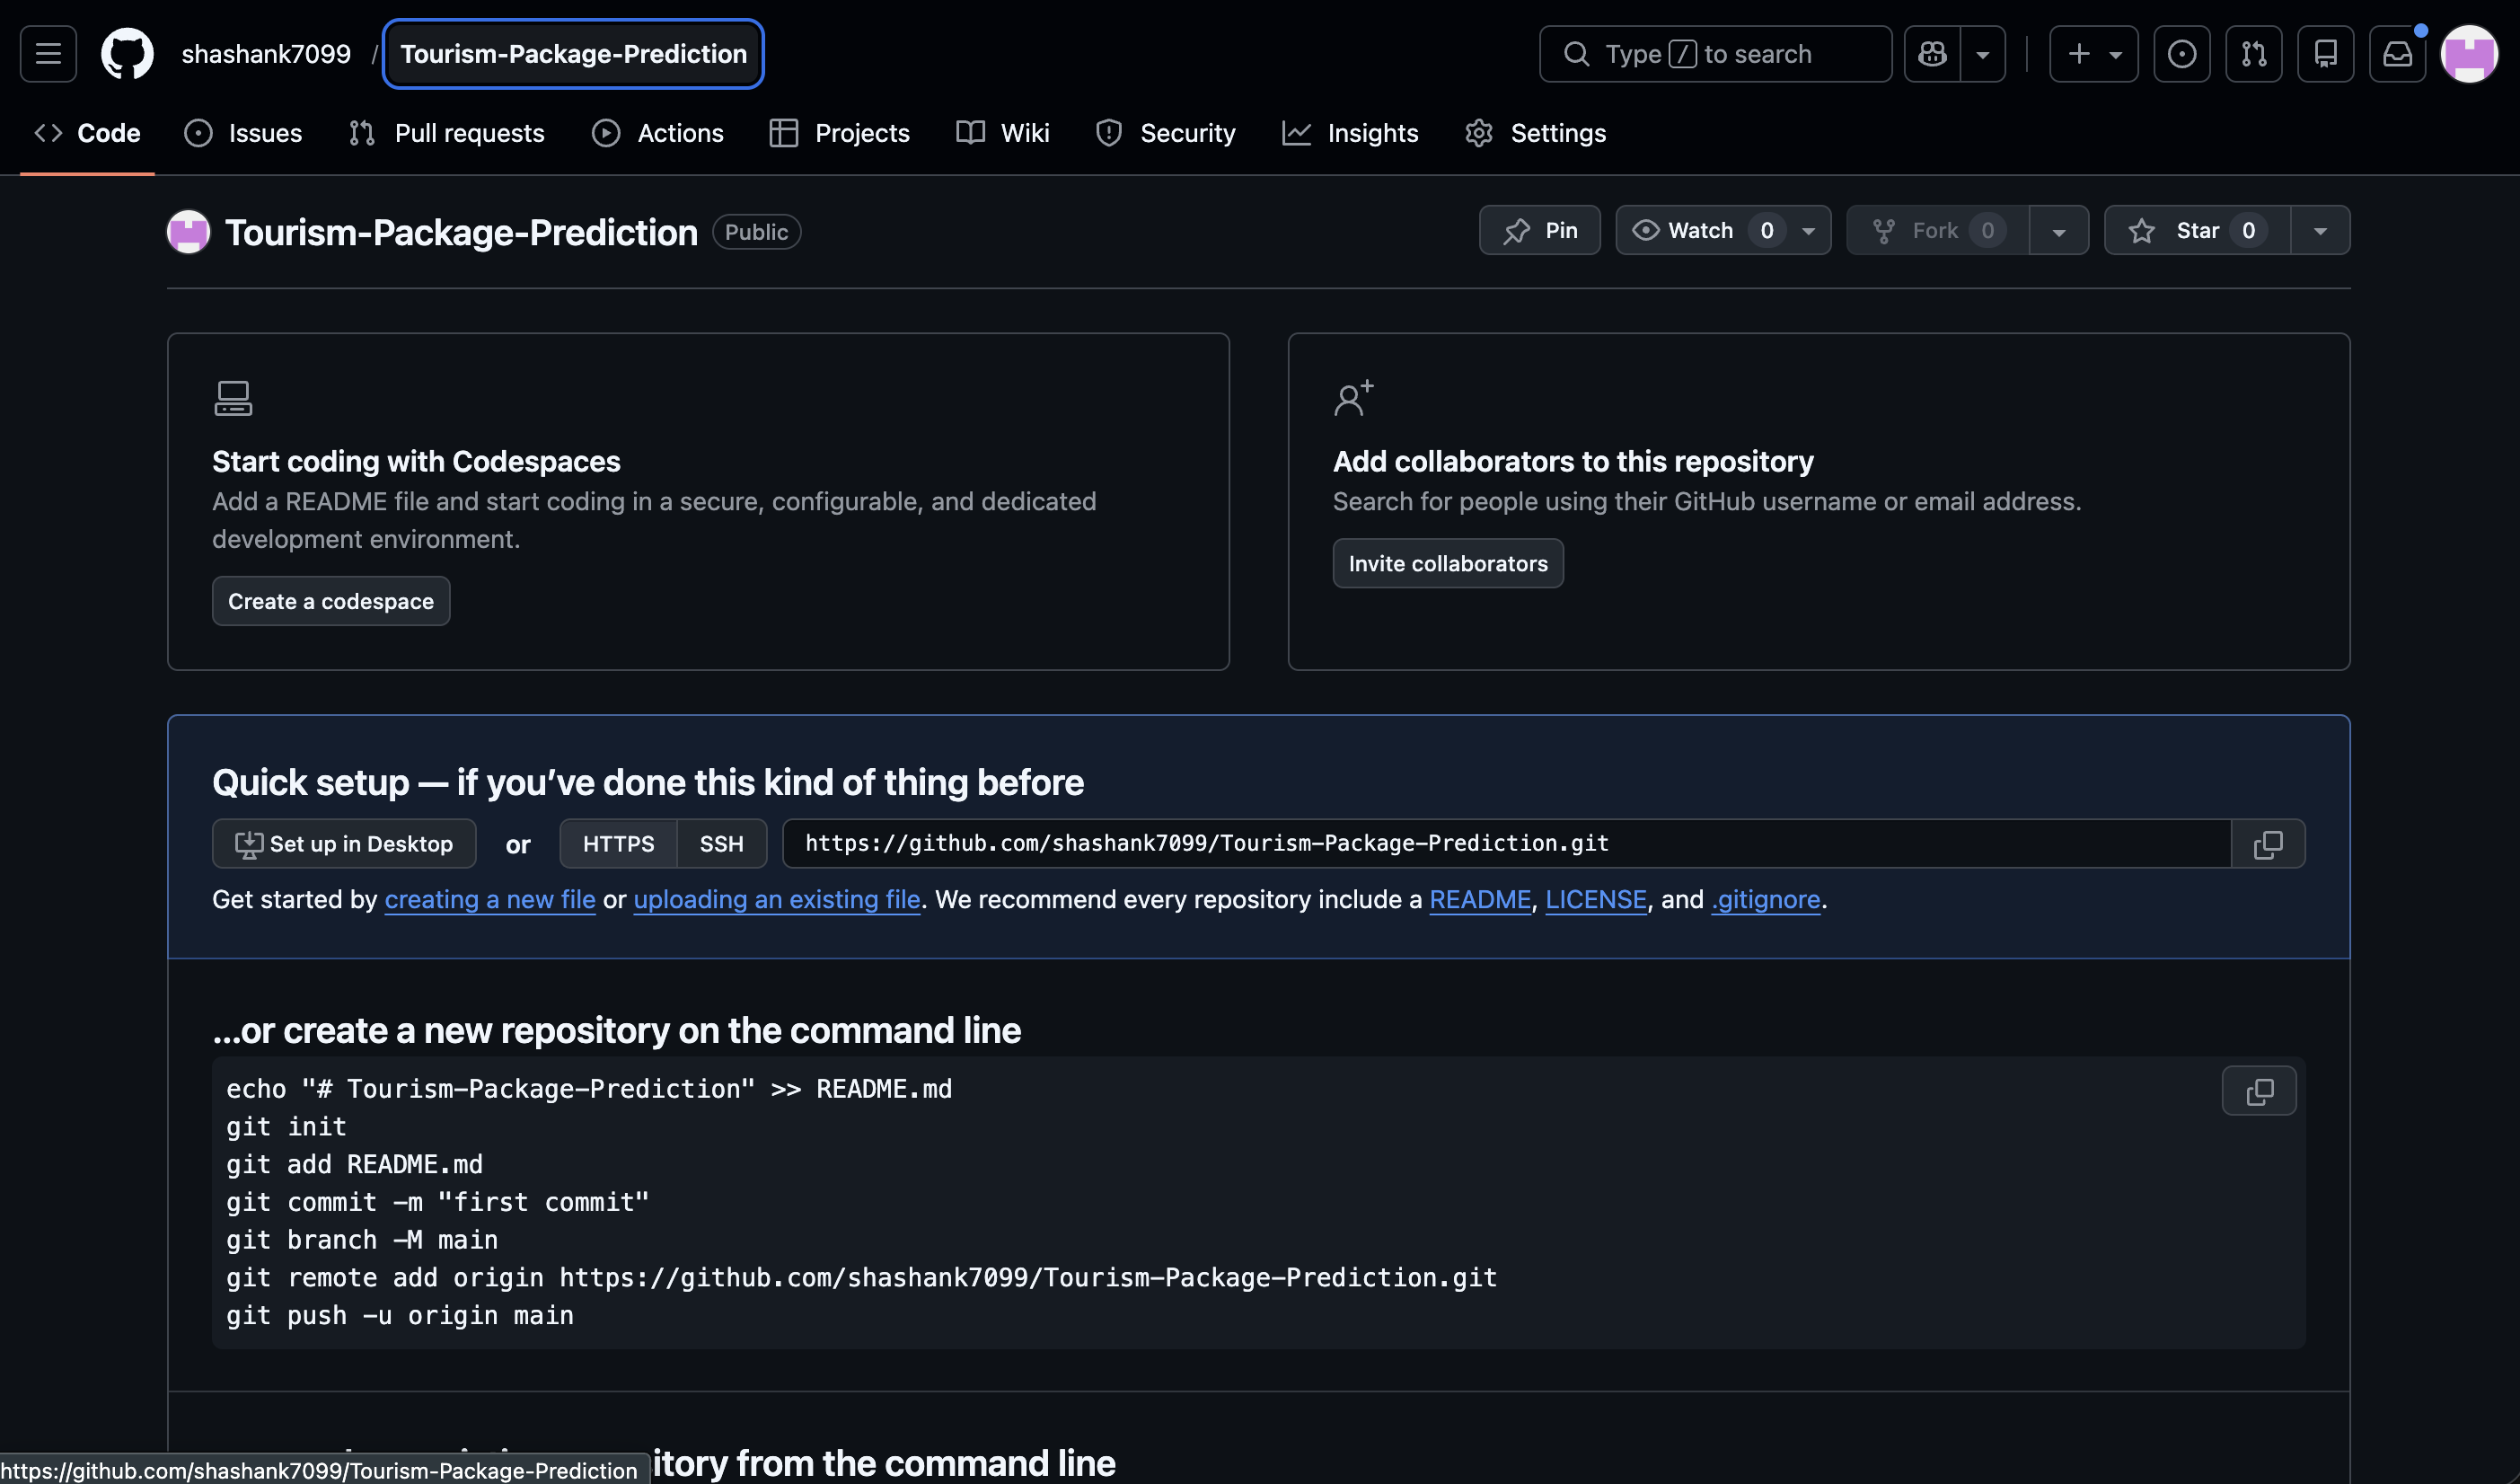

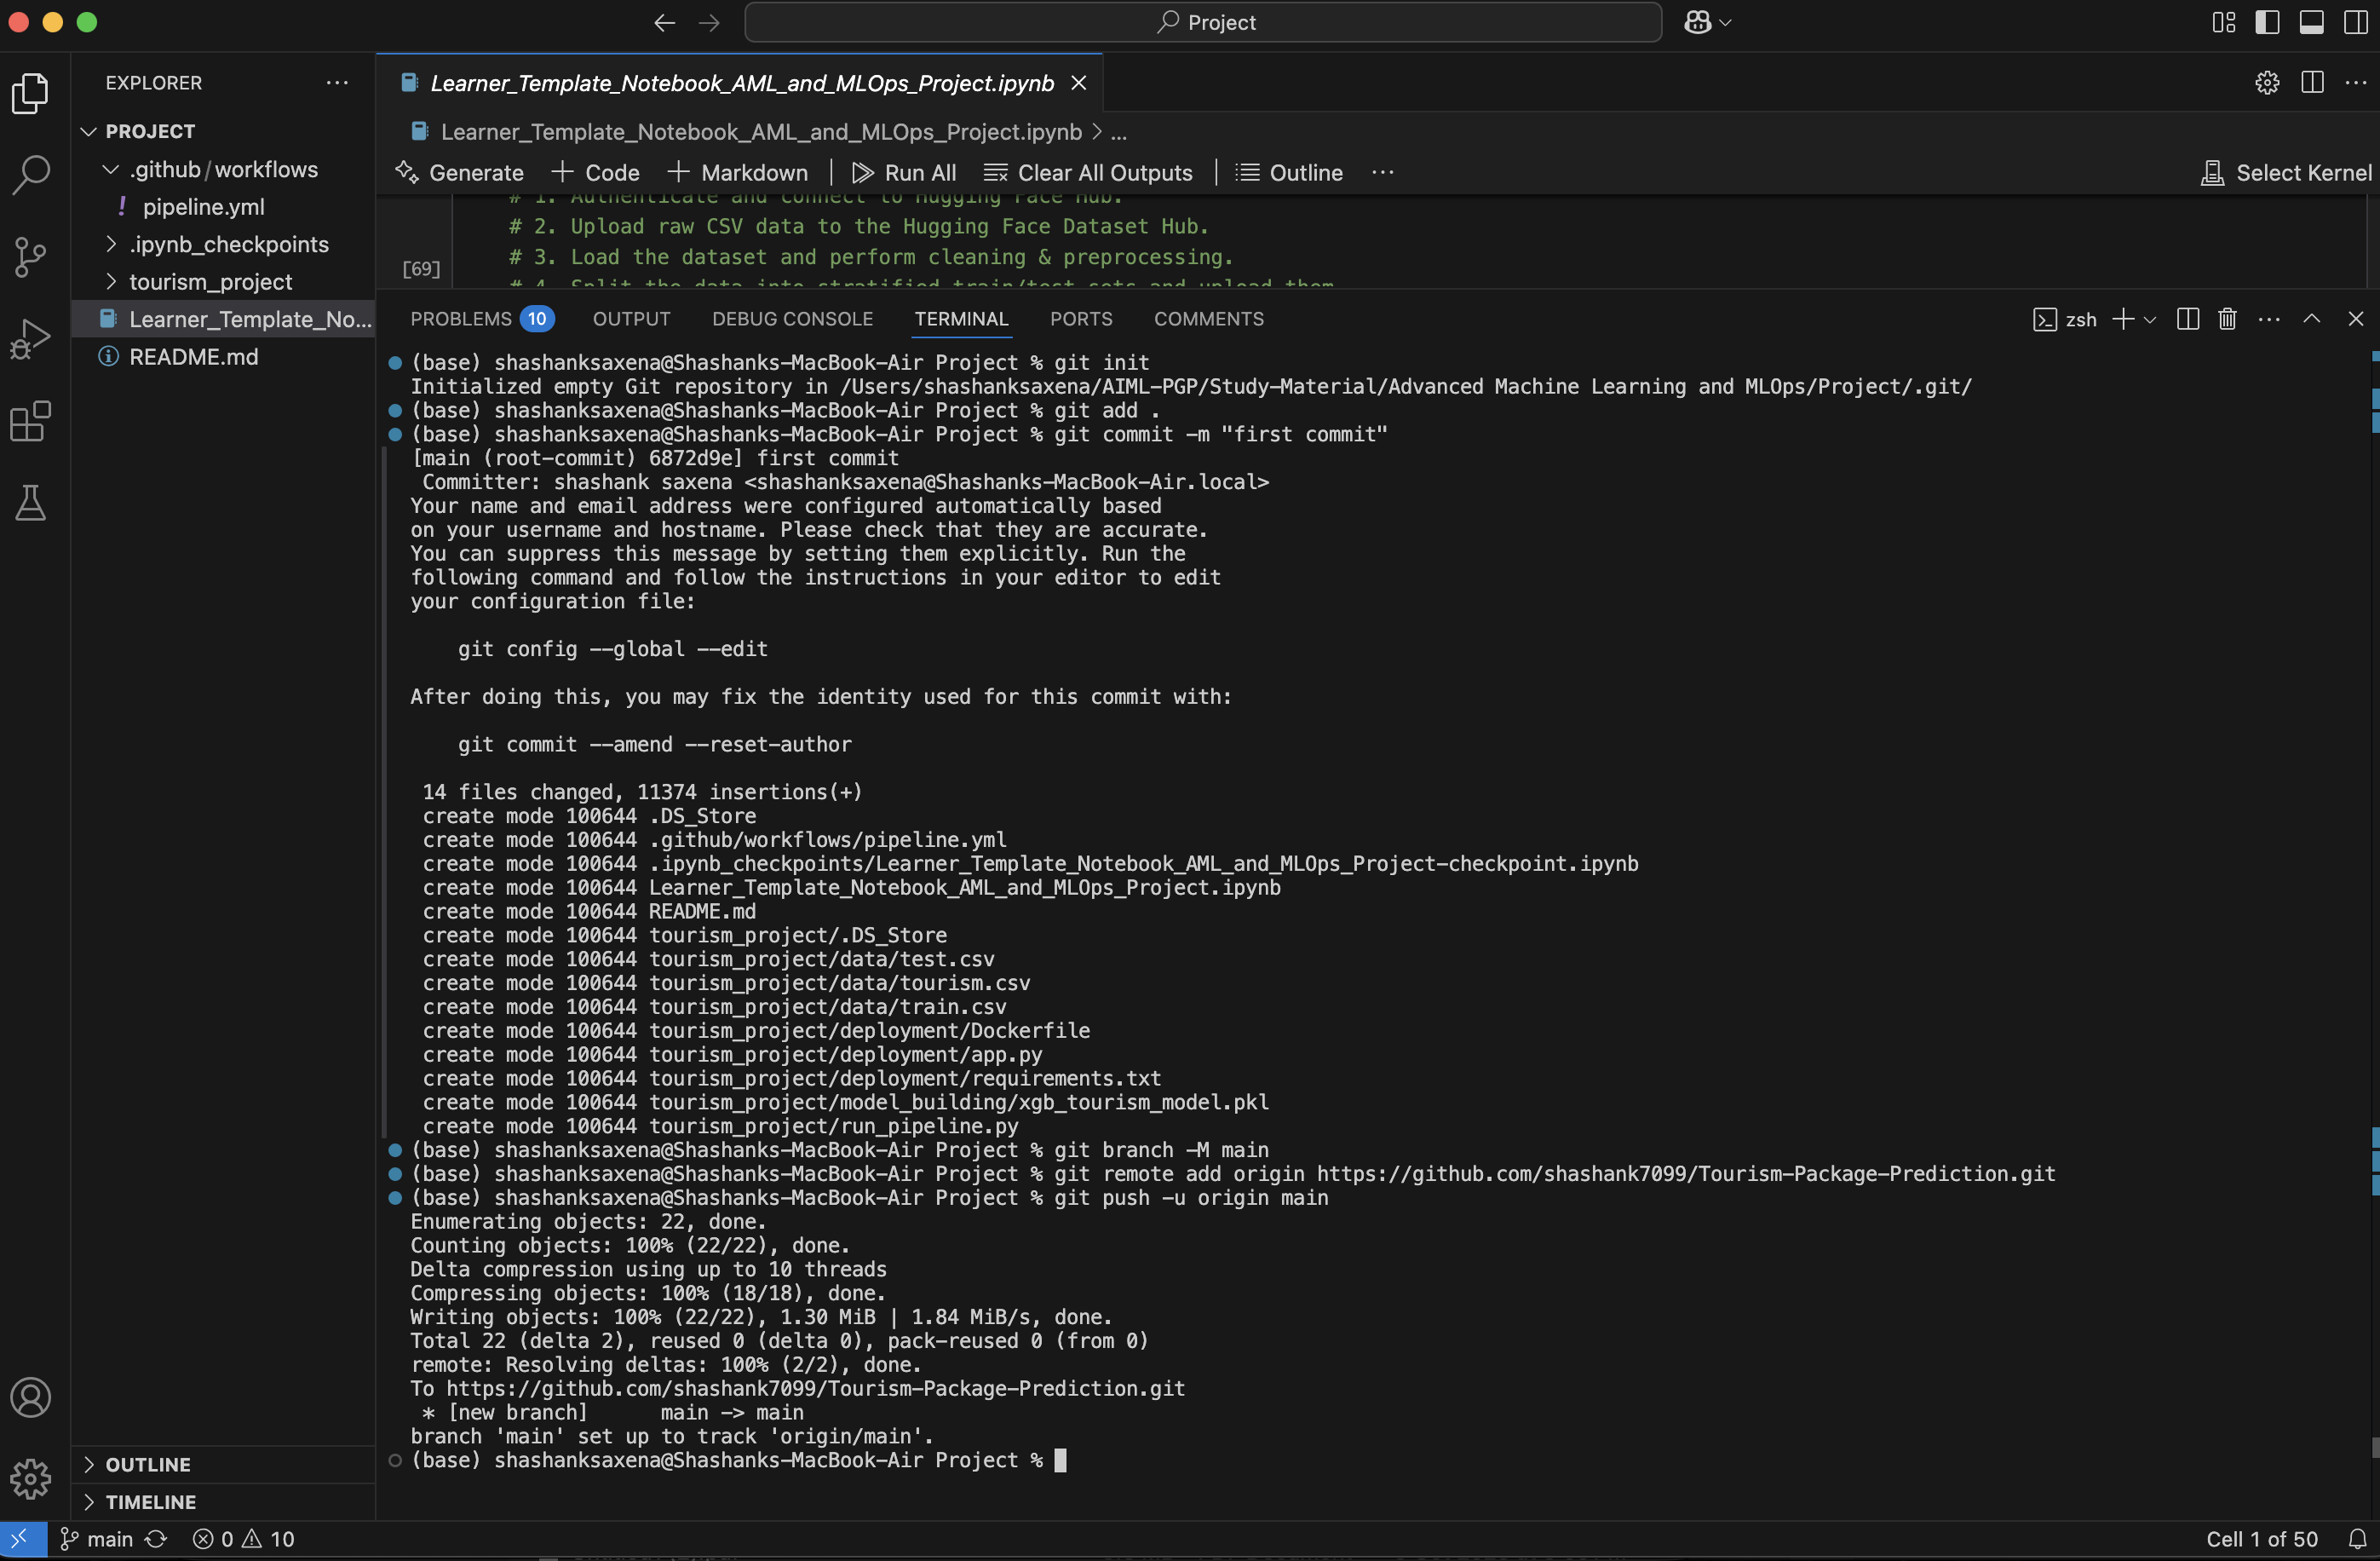


## Project Link

You can access the full project repository here:  
[Tourism Package Prediction GitHub Repository](https://github.com/shashank7099/Tourism-Package-Prediction)


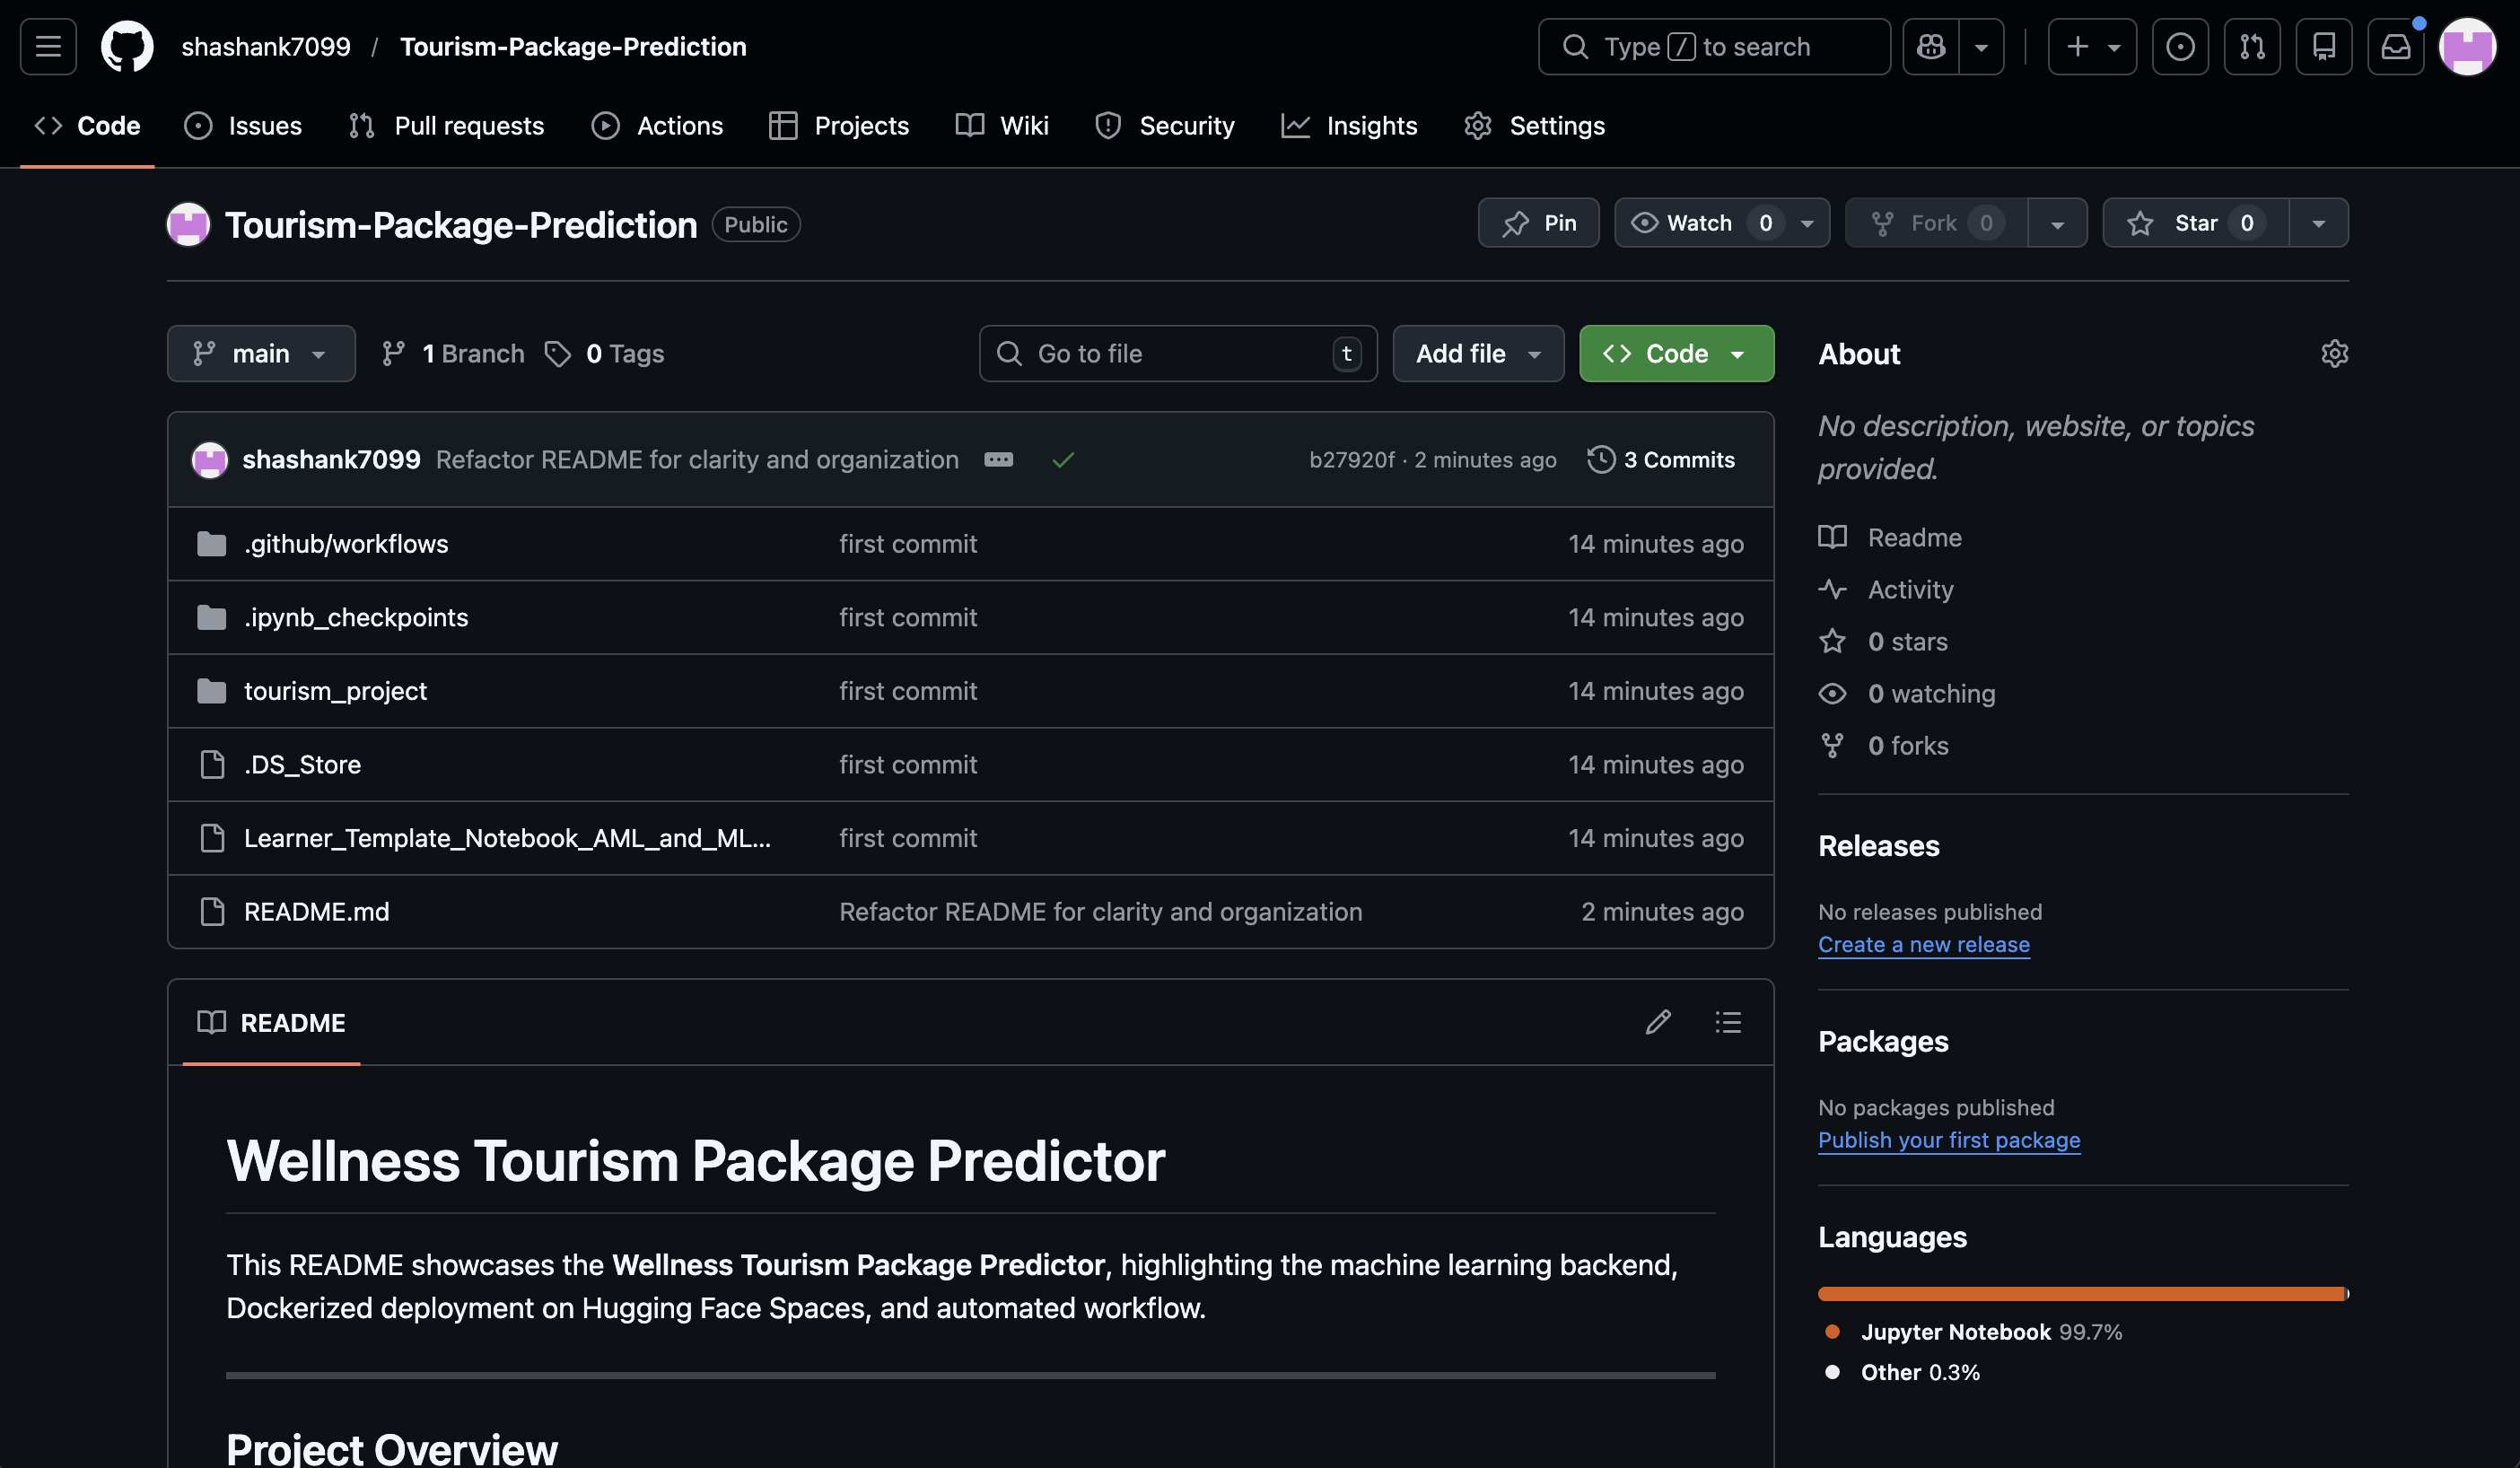

# Output Evaluation CI/CD